In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, CuDNNLSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error

import datetime
import time
import tensorflow as tf

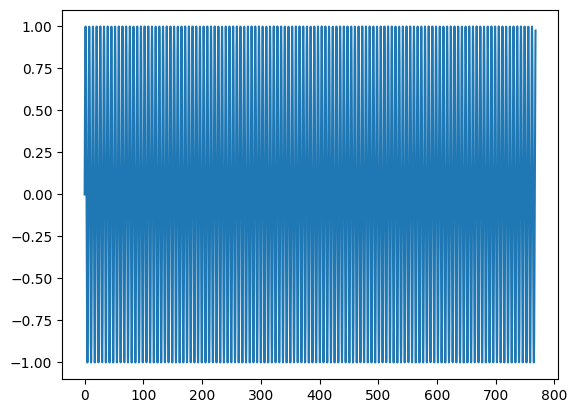

In [ ]:
time = np.arange(0,768,0.1);
amplitute = np.sin(time)
plt.plot(time,amplitute)

In [ ]:
#using the MachineLearningMastery formula for splitting up the dataset to predictors and target
#reference: https://towardsdatascience.com/single-and-multi-step-temperature-time-series-forecasting-for-vilnius-using-lstm-deep-learning-b9719a0009de
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [ ]:
lag = 256
n_ahead = 128
train_share = 0.7
val_share = 0.8
epochs = 10
batch_size = 1

In [ ]:
data = amplitute.reshape(-1,1)
scaler = MinMaxScaler()
scaler.fit(data)
ts_scaled = scaler.transform(data)

In [ ]:
X, Y = create_X_Y(ts_scaled, lag=lag, n_ahead=n_ahead)

In [ ]:
Xtrain, Ytrain = X[0:int(X.shape[0]* train_share)], Y[0:int(X.shape[0]*train_share)]
Xtest, Ytest = X[int(X.shape[0] * val_share):], Y[int(X.shape[0]*val_share):]
Xval, Yval = X[int(X.shape[0] * train_share):int(X.shape[0]*val_share)], Y[int(X.shape[0]*train_share):int(X.shape[0]*val_share)]

In [ ]:
model = Sequential()

#model.add(LSTM(16, activation='tanh', input_shape=(Xtrain.shape[1], Xtrain.shape[2]), return_sequences=True))
model.add(CuDNNLSTM(16,input_shape=(Xtrain.shape[1], Xtrain.shape[2]), return_sequences=True))
#model.add(LSTM(8, activation='tanh', return_sequences=False))
model.add(CuDNNLSTM(8,return_sequences=False))
model.add(Dense(128))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)
model.summary()

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics='mae')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm (CuDNNLSTM)      (None, 256, 16)           1216      
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 8)                 832       
                                                                 
 dense (Dense)               (None, 128)               1152      
                                                                 
Total params: 3,200
Trainable params: 3,200
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(Xtrain, Ytrain, epochs=epochs, validation_data=(Xval, Yval), shuffle=False, callbacks=[early_stopping])

Epoch 1/10
160/160 [==============================] - 20s 31ms/step - loss: 0.3663 - mae: 0.3663 - val_loss: 0.3162 - val_mae: 0.3162
Epoch 2/10
160/160 [==============================] - 4s 27ms/step - loss: 0.2750 - mae: 0.2750 - val_loss: 0.1904 - val_mae: 0.1904
Epoch 3/10
160/160 [==============================] - 5s 30ms/step - loss: 0.0949 - mae: 0.0949 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 4/10
160/160 [==============================] - 3s 18ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0099 - val_mae: 0.0099
Epoch 5/10
160/160 [==============================] - 2s 16ms/step - loss: 0.0092 - mae: 0.0092 - val_loss: 0.0087 - val_mae: 0.0087
Epoch 6/10
160/160 [==============================] - 2s 15ms/step - loss: 0.0071 - mae: 0.0071 - val_loss: 0.0061 - val_mae: 0.0061
Epoch 7/10
160/160 [==============================] - 3s 19ms/step - loss: 0.0059 - mae: 0.0059 - val_loss: 0.0050 - val_mae: 0.0050
Epoch 8/10
160/160 [==============================] - 2s 15ms/step -

In [ ]:
yhat = model.predict(Xtest)
yhat.shape

46/46 [==============================] - 1s 8ms/step


(1460, 128)

In [ ]:
pred_n_ahead = pd.DataFrame(yhat[0])
actual_n_ahead = pd.DataFrame(Ytest[0])

pred_n_ahead = pd.DataFrame(scaler.inverse_transform(pred_n_ahead))
actual_n_ahead = pd.DataFrame(scaler.inverse_transform(actual_n_ahead))

<function matplotlib.pyplot.show(close=None, block=None)>

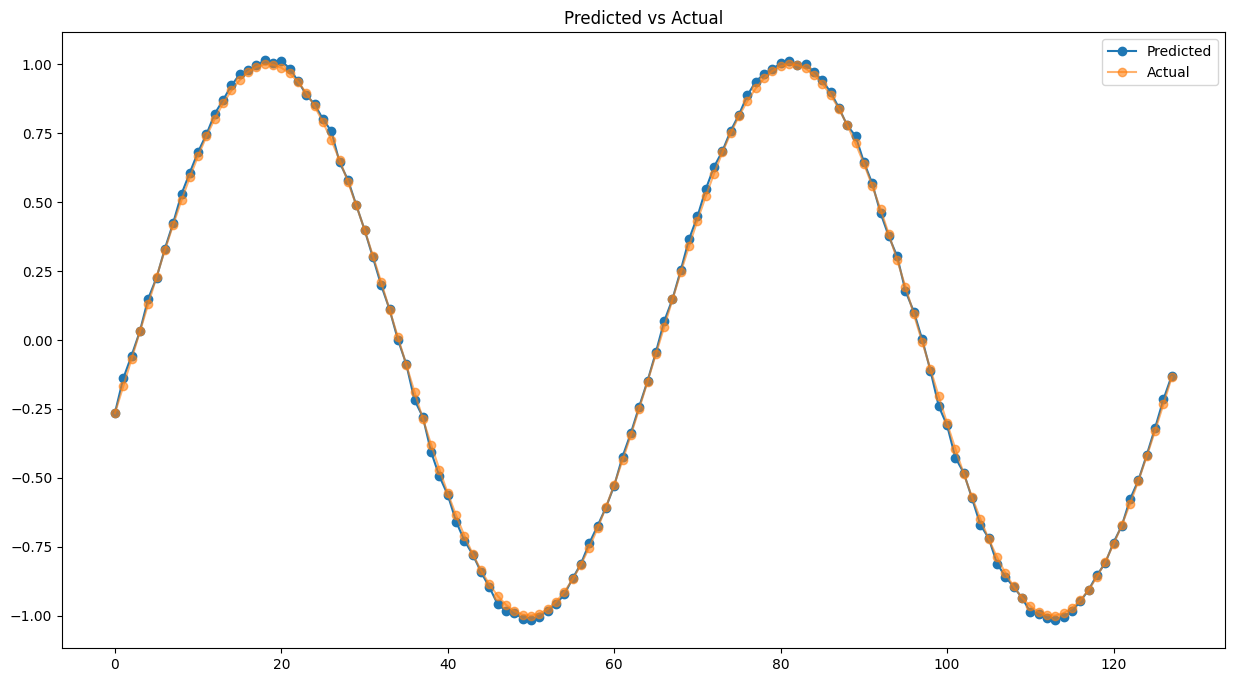

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(pred_n_ahead, color='C0', marker='o', label='Predicted')
plt.plot(actual_n_ahead, color='C1', marker='o', label='Actual', alpha=0.6)
plt.title('Predicted vs Actual')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.legend()
plt.show

In [ ]:
def forecast_accuracy(forecast,actual):
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
  me = np.mean(forecast - actual)
  mae = np.mean(np.abs(forecast - actual))
  rmse = np.mean((forecast - actual)**2)**.5
  corr = np.corrcoef(forecast,actual)[0,1]
  return({'mape':mape, 'me':me, 'mae':mae, 'rmse':rmse, 'corr':corr})

forecast_accuracy(yhat,Ytest)

{'mape': 2.926150124111541,
 'me': 0.00017844743909433498,
 'mae': 0.004665744278250302,
 'rmse': 0.005934764109297747,
 'corr': 0.9948532230393078}